In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sea
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import pickle

# importing classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

# -------------------- PARAMETERS --------------------

In [2]:
# name of the file with dataset
filename = 'mtg_dataset'

In [3]:
# importing dataset from the .cvs file with chosen name
df = pd.read_csv('Datasets\\' + filename + '.csv', sep=';')

In [4]:
# which columns are treated as numeric
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [5]:
# columns to exclude from learning process
columns_to_exclude = ['name','set']
colors_excludes = ['color', 'devotion','manasymbols','price']

In [6]:
# percent of objects that will serve as testing set
test_size = 0.2

In [7]:
# paramenters of random number generator
random_state = 0
random.seed(random_state)

In [8]:
# choosen classifier
classifier_prefab = RandomForestClassifier(class_weight=None, criterion='entropy', min_samples_leaf=1, n_estimators=200, random_state=random_state)

# RandomForestClassifier(class_weight=None, criterion='entropy', min_samples_leaf=1, n_estimators=200, random_state=random_state)
# AdaBoostClassifier(n_estimators=200, learning_rate=0.9, random_state=random_state)
# KNeighborsClassifier(n_neighbors=7, weights='distance', metric='cityblock')
# MLPClassifier(max_iter=1000, activation='relu', hidden_layer_sizes=(100, 50, 25), solver='adam', random_state=random_state)

In [9]:
# whether the data should be balanced in terms of the distribution of the decision class
doBalance = True

In [10]:
# whether data should be truncated or cloned to balance it
upcast = False

In [11]:
# number of fold used to crossvalidate
number_of_folds = 5

In [12]:
# predefined colors with name | column name | chart color map
colors_dict = {
    'colorless': ['Colorless cards','Greys'],
    'colors_B': ['Black cards','Purples'],
    'colors_G': ['Green cards','Greens'],
    'colors_R': ['Red cards','Reds'],
    'colors_U': ['Blue cards','Blues'],
    'colors_W': ['White cards','YlOrBr']
}

In [13]:
parameters_to_test = {
    'activation': ['logistic','relu'],
    'solver': ['sgd','adam'],
    'hidden_layer_sizes': [(100), (100,50), (50,25), (100,50,25)]
}

# -------------------- BEST PARAMETERS --------------------

##### RandomForestClassifier

parameters_to_test = {
    'n_estimators': [10, 20, 100, 200],
    'criterion': ['gini','entropy'],
    'min_samples_leaf': [1, 5, 7],
    'class_weight': [None, 'balanced']
}

In [14]:
RandomForestClassifier_best_params = {
    'class_weight': None,
    'criterion': 'entropy',
    'min_samples_leaf': 1,
    'n_estimators': 200
}

##### KNeighborsClassifier

parameters_to_test = {
    'n_neighbors': [1,3,5,7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean','cityblock','chebyshev']
}

In [15]:
KNeighborsClassifier_best_params = {
    'n_neighbors': 7,
    'weights': 'distance',
    'metric': 'cityblock'
}

##### MLPClassifier

parameters_to_test = {
    'activation': ['logistic','relu'],
    'solver': ['sgd','adam'],
    'hidden_layer_sizes': [(100), (100,50), (50,25), (100,50,25)]
}

In [16]:
MLPClassifier_best_params = {
    'activation': 'relu',
    'solver': 'adam',
    'hidden_layer_sizes': (100, 50, 25)
}

##### AdaBoostClassifier

parameters_to_test = {
    'n_estimators': [10, 20, 100, 200],
    'learning_rate': [0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
}

In [17]:
AdaBoostClassifier_best_params = {
    'n_estimators': 200,
    'learning_rate': 0.9
}

# --------------------------- DATA ---------------------------

In [18]:
# dataset preview
df.head()

,name,set,dfc,prints,layout,flavor_text,type_creature,type_artifact,type_enchantment,type_planeswalker,...,custom_wish,custom_cheatinto_play,custom_ritual,custom_no_maximum,custom_wheel,custom_extra_combat,custom_pillow_fort,custom_land_destruction,custom_win_game,custom_lose_game
0,Fury Sliver,tsp,0.0,3,normal,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Kor Outfitter,zen,0.0,2,normal,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Siren Lookout,xln,0.0,1,normal,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Venerable Knight,eld,0.0,1,normal,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Wildcall,ugin,0.0,2,normal,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# -------------------- FUNCTIONS --------------------

In [19]:
# function to normalize columns with numeric values
def normalize_data_frame(data):
    scaler = MinMaxScaler()
    scaler.fit(data)
    scaled = scaler.fit_transform(data)
    scaled_df = pd.DataFrame(scaled, columns=data.columns)
    return pd.DataFrame(scaled_df)

In [20]:
# function to exclude unwanted columns
def prepare_for_model(data, decision_class, numeric_only, columns_excludes):
    y = data[decision_class]
    x = data.loc[:, ~data.columns.isin(columns_to_exclude)]
    
    for exclude in columns_excludes:
        x = x.loc[:, ~x.columns.str.contains(exclude)]
        
    if numeric_only == True:
        x = x.select_dtypes(include=numerics)
        
    if decision_class not in x:
        x[decision_class] = y
    
    return x

In [21]:
# spliting data into training and test sets balancing them
def custom_train_test_split(decision_class, x, test_size, upcast):
    decision_class_values = x[decision_class].unique()
    
    x_values = {}
    for d_val in decision_class_values:
        x_values[d_val] = x.loc[x[decision_class] == d_val]
    
    
    min_count = x_values[decision_class_values[0]].shape[0]
    max_count = x_values[decision_class_values[0]].shape[0]
    for i in range(0, len(decision_class_values)-1):
        min_count = min(x_values[decision_class_values[i]].shape[0], x_values[decision_class_values[i+1]].shape[0])
        max_count = max(x_values[decision_class_values[i]].shape[0], x_values[decision_class_values[i+1]].shape[0])
    
   
    for d_val in decision_class_values:
        x_values[d_val] = x_values[d_val].sample(n=min_count, random_state=random_state)
        
    
    if upcast:
        diff_count = max_count - min_count
        while diff_count > 0:
            number_to_add = min(diff_count, min_count)
            for d_val in decision_class_values:
                x_values[d_val] = x_values[d_val].append(x_values[d_val].sample(n=number_to_add))
            diff_count = diff_count - min_count
            
    
    new_x = x_values[decision_class_values[0]]
    for i in range(0, len(decision_class_values)-1):
        new_x = new_x.append(x_values[decision_class_values[i+1]])
    
    
    y_values = {}
    for d_val in decision_class_values:
        y_values[d_val] = (x_values[d_val])[decision_class]

    
    for d_val in decision_class_values:
        x_values[d_val] = x_values[d_val].drop(decision_class, axis=1)
    
    x_train, x_test, y_train, y_test = train_test_split(x_values[decision_class_values[0]], y_values[decision_class_values[0]], test_size=test_size)
    for i in range(0, len(decision_class_values)-1):
        x_i_train, x_i_test, y_i_train, y_i_test = train_test_split(x_values[decision_class_values[i+1]], y_values[decision_class_values[i+1]], test_size=test_size)
        x_train = x_train.append(x_i_train)
        x_test = x_test.append(x_i_test)
        y_train = y_train.append(y_i_train)
        y_test = y_test.append(y_i_test)
         
    return x_train, x_test, y_train, y_test, new_x

In [22]:
# training classifier and printing out its scores
def training_statistics(decision_class, x, classifier, doBalance, n, cmap):   
    
    (x.groupby(decision_class))[decision_class].count().plot.bar(ylim=0)
    print((x.groupby(decision_class))[decision_class].count())
    plt.title(str(colors_dict[decision_class][0]) + " - histogram",fontweight ="bold")
    plt.show()
    
    if doBalance:
        x_train, x_test, y_train, y_test, new_x = custom_train_test_split(decision_class, x, test_size=n, upcast=upcast)
        (new_x.groupby(decision_class))[decision_class].count().plot.bar(ylim=0)
        print((new_x.groupby(decision_class))[decision_class].count())
        plt.title(str(colors_dict[decision_class][0]) + " - histogram after balance",fontweight ="bold")
        plt.show()
    else:
        x_train, x_test, y_train, y_test = train_test_split(x.loc[:, ~x.columns.isin([decision_class])], x[decision_class], test_size=n)
        new_x = x
    
    cross_scoring = ['accuracy', 'precision','recall','f1_micro','roc_auc']
    scores = cross_validate(classifier, new_x.loc[:, ~new_x.columns.isin([decision_class])], new_x[decision_class], cv=number_of_folds, scoring=cross_scoring)
    
    trained_classifier = classifier.fit(x_train, y_train)
    predicted = trained_classifier.predict(x_test)
    
    print("Training results for " + str(decision_class) + ":")
    accuracy = scores['test_accuracy'].mean()
    print("Accuracy: " + str(accuracy))
    precision = scores['test_precision'].mean()
    print("Precision: " + str(precision))
    recall = scores['test_recall'].mean()
    print("Recall: " + str(recall))
    f1 = scores['test_f1_micro'].mean()
    print("F1 Score: " + str(f1))
    roc = scores['test_roc_auc'].mean()
    print("ROC Area: " + str(roc))
    conf_mat = metrics.confusion_matrix(y_test, predicted)
    
    print("Confusion Matrix: ")
    confusion_matrix = sea.heatmap(conf_mat, annot=True, fmt='d', cmap=cmap).set(title=colors_dict[decision_class][0], 
                                                              ylabel='Actual value', 
                                                              xlabel='Predicted value')
    #plt.savefig(colors_dict[decision_class][0] + ".svg")

    return pickle.dumps(trained_classifier)

In [23]:
# finding best set of parameters for given dataframe
def find_best_parameters(decision_class, x, classifier, doBalance, n):
    
    if doBalance:
        x_train, x_test, y_train, y_test, new_x = custom_train_test_split(decision_class, x, test_size=n, upcast=upcast)
    else:
        x_train, x_test, y_train, y_test = train_test_split(x.loc[:, ~x.columns.isin([decision_class])], x[decision_class], test_size=n)
        new_x = x
        
    classifierGS = GridSearchCV(
        classifier, 
        param_grid=parameters_to_test,
        scoring='accuracy',
        cv=number_of_folds,
        verbose=3
    )
    trained_classifier = classifierGS.fit(x_train, y_train)
    
    print("Done")
    
    return trained_classifier.best_params_, trained_classifier.cv_results_

In [24]:
def best_features_for_RandomForest(x, classifier):
    feature_imps = pd.DataFrame()
    feature_imps['feature'] = x.columns[:-1]
    feature_imps['importance'] = (classifier.feature_importances_).tolist()
    return feature_imps.sort_values(by='importance', ascending=False)

# -------------------- Tests --------------------

# --- Colors ---

colorless
0.0    31515
1.0     3826
Name: colorless, dtype: int64


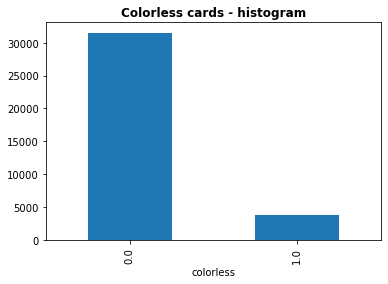

colorless
0.0    3826
1.0    3826
Name: colorless, dtype: int64


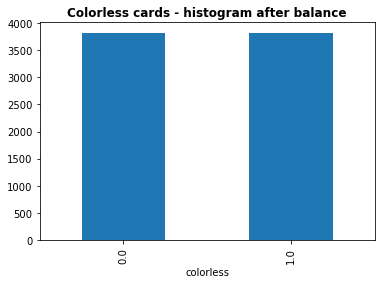

Training results for colorless:
Accuracy: 0.9831411824472877
Precision: 0.9812582295712133
Recall: 0.9851021348487177
F1 Score: 0.9831411824472877
ROC Area: 0.9961204937022392
Confusion Matrix: 


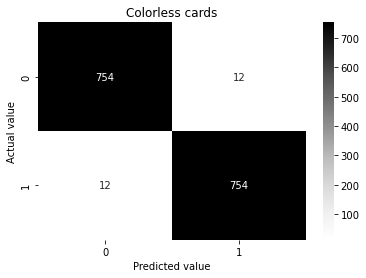

In [25]:
x = prepare_for_model(df, 'colorless', True, colors_excludes)

classifier = classifier_prefab
trained_classifier_colorless = training_statistics('colorless', x, classifier, doBalance, test_size, 'Greys')

best_features_for_RandomForest(x, pickle.loads(trained_classifier_colorless)).head()

colors_B
0.0    27763
1.0     7578
Name: colors_B, dtype: int64


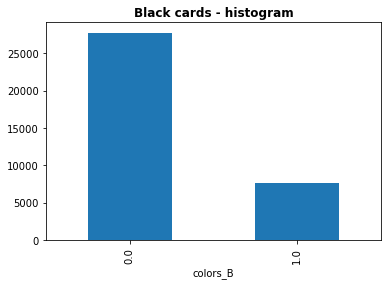

colors_B
0.0    7578
1.0    7578
Name: colors_B, dtype: int64


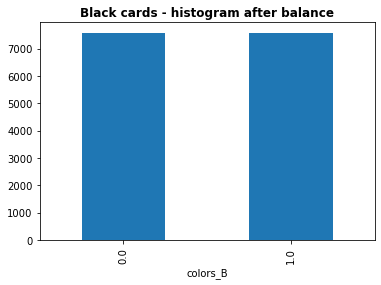

Training results for colors_B:
Accuracy: 0.8245581715413899
Precision: 0.8150674503630562
Recall: 0.8399318164006374
F1 Score: 0.8245581715413899
ROC Area: 0.9106256521087606
Confusion Matrix: 


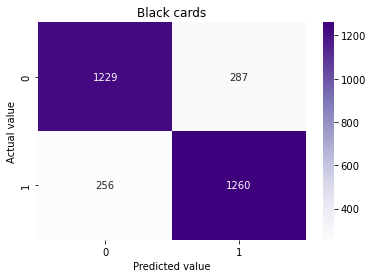

In [26]:
x = prepare_for_model(df, 'colors_B', True, colors_excludes)

classifier = classifier_prefab
trained_classifier_black = training_statistics('colors_B', x, classifier, doBalance, test_size, 'Purples')

best_features_for_RandomForest(x, pickle.loads(trained_classifier_black)).head()

colors_G
0.0    27677
1.0     7664
Name: colors_G, dtype: int64


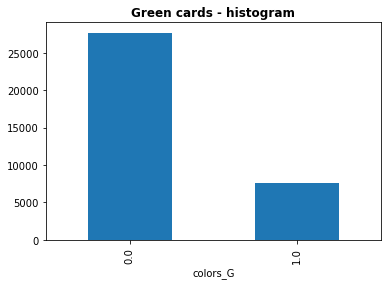

colors_G
0.0    7664
1.0    7664
Name: colors_G, dtype: int64


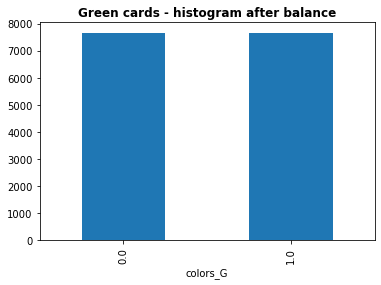

Training results for colors_G:
Accuracy: 0.8247646289515382
Precision: 0.8065764227241463
Recall: 0.8546429380436319
F1 Score: 0.8247646289515382
ROC Area: 0.9121971261725017
Confusion Matrix: 


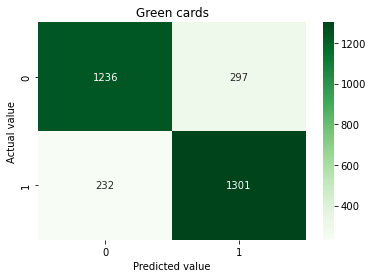

In [27]:
x = prepare_for_model(df, 'colors_G', True, colors_excludes)

classifier = classifier_prefab
trained_classifier_green = training_statistics('colors_G', x, classifier, doBalance, test_size, 'Greens')

best_features_for_RandomForest(x, pickle.loads(trained_classifier_green)).head()

colors_R
0.0    27877
1.0     7464
Name: colors_R, dtype: int64


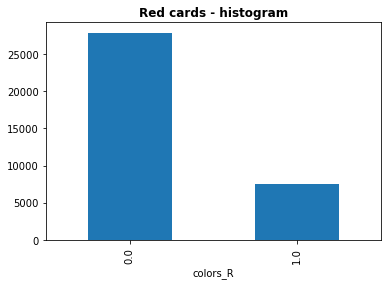

colors_R
0.0    7464
1.0    7464
Name: colors_R, dtype: int64


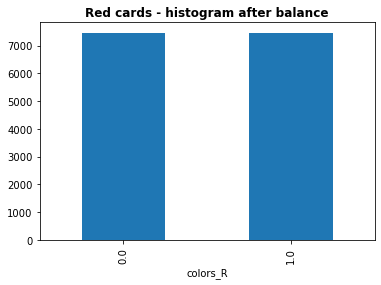

Training results for colors_R:
Accuracy: 0.8173235231751523
Precision: 0.8032336195158203
Recall: 0.8405688566303159
F1 Score: 0.8173235231751523
ROC Area: 0.9088528869337354
Confusion Matrix: 


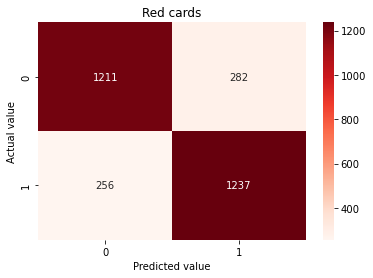

In [28]:
x = prepare_for_model(df, 'colors_R', True, colors_excludes)

classifier = classifier_prefab
trained_classifier_red = training_statistics('colors_R', x, classifier, doBalance, test_size, 'Reds')

best_features_for_RandomForest(x, pickle.loads(trained_classifier_red)).head()

colors_U
0.0    27954
1.0     7387
Name: colors_U, dtype: int64


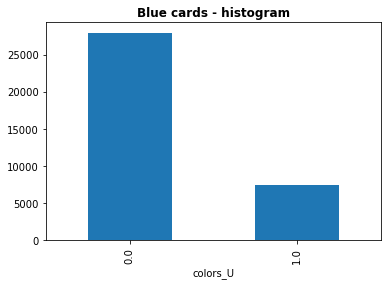

colors_U
0.0    7387
1.0    7387
Name: colors_U, dtype: int64


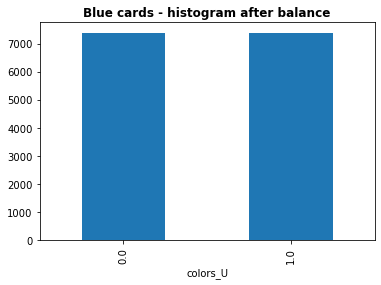

Training results for colors_U:
Accuracy: 0.8282115047765684
Precision: 0.8135404256887346
Recall: 0.8516302749511453
F1 Score: 0.8282115047765684
ROC Area: 0.9141536244931304
Confusion Matrix: 


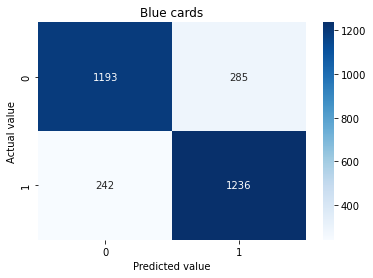

In [29]:
x = prepare_for_model(df, 'colors_U', True, colors_excludes)

classifier = classifier_prefab
trained_classifier_blue = training_statistics('colors_U', x, classifier, doBalance, test_size, 'Blues')

best_features_for_RandomForest(x, pickle.loads(trained_classifier_blue)).head()

colors_W
0.0    27890
1.0     7451
Name: colors_W, dtype: int64


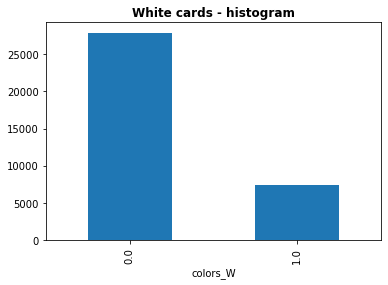

colors_W
0.0    7451
1.0    7451
Name: colors_W, dtype: int64


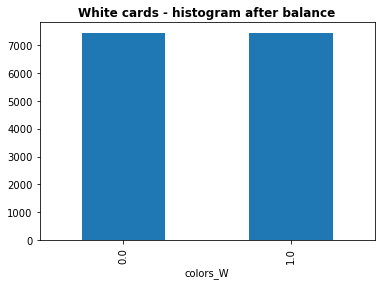

Training results for colors_W:
Accuracy: 0.8000937481003852
Precision: 0.774496107228677
Recall: 0.8467316651587377
F1 Score: 0.8000937481003852
ROC Area: 0.8910521210834818
Confusion Matrix: 


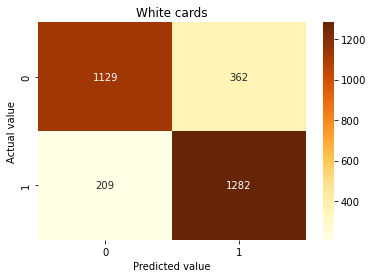

In [30]:
x = prepare_for_model(df, 'colors_W', True, colors_excludes)

classifier = classifier_prefab
trained_classifier_white = training_statistics('colors_W', x, classifier, doBalance, test_size, 'YlOrBr')

best_features_for_RandomForest(x, pickle.loads(trained_classifier_white)).head()

# -------------------- CARD PREDICTION --------------------

In [31]:
random_card = df.loc[df['name'] == 'Mana Drain'].sample(n=1, random_state=0)
random_card

,name,set,dfc,prints,layout,flavor_text,type_creature,type_artifact,type_enchantment,type_planeswalker,...,custom_wish,custom_cheatinto_play,custom_ritual,custom_no_maximum,custom_wheel,custom_extra_combat,custom_pillow_fort,custom_land_destruction,custom_win_game,custom_lose_game
31439,Mana Drain,cmr,0.0,6,normal,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
print("Card predictions for:")
print(str(random_card['name']))
print('\n')

x = prepare_for_model(random_card, 'colorless', True, colors_excludes)
print(x.shape)
prediction_colorless = pickle.loads(trained_classifier_colorless).predict_proba(x.loc[:, ~x.columns.isin(['colorless'])])
print("Card is colorless: " + str(prediction_colorless[0]))

x = prepare_for_model(random_card, 'colors_B', True, colors_excludes)
prediction_black = pickle.loads(trained_classifier_black).predict_proba(x.loc[:, ~x.columns.isin(['colors_B'])])
print("Card is black: " + str(prediction_black[0]))

x = prepare_for_model(random_card, 'colors_G', True, colors_excludes)
prediction_green = pickle.loads(trained_classifier_green).predict_proba(x.loc[:, ~x.columns.isin(['colors_G'])])
print("Card is green: " + str(prediction_green[0]))

x = prepare_for_model(random_card, 'colors_R', True, colors_excludes)
prediction_red = pickle.loads(trained_classifier_red).predict_proba(x.loc[:, ~x.columns.isin(['colors_R'])])
print("Card is red: " + str(prediction_red[0]))

x = prepare_for_model(random_card, 'colors_U', True, colors_excludes)
prediction_blue = pickle.loads(trained_classifier_blue).predict_proba(x.loc[:, ~x.columns.isin(['colors_U'])])
print("Card is blue: " + str(prediction_blue[0]))

x = prepare_for_model(random_card, 'colors_W', True, colors_excludes)
prediction_white = pickle.loads(trained_classifier_white).predict_proba(x.loc[:, ~x.columns.isin(['colors_W'])])
print("Card is white: " + str(prediction_white[0]))

Card predictions for:
31439    Mana Drain
Name: name, dtype: object


(1, 450)
Card is colorless: [0.8 0.2]
Card is black: [0.74 0.26]
Card is green: [0.765 0.235]
Card is red: [0.925 0.075]
Card is blue: [0.015 0.985]
Card is white: [0.965 0.035]


# -------------------- BEST PARAMETERS --------------------

x = prepare_for_model(df, 'colors_W', True, colors_excludes)

classifier = classifier_prefab
best_params, cv_results = find_best_parameters('colors_W', x, classifier, doBalance, test_size)

best_params

GSresults = pd.DataFrame(cv_results)
GSresults.head()

GSresults.to_csv("GSresults.csv", index=False, sep=';')